# Nonlinear estimation: Full Bayesian, MLE and MAP

## Intro
Recently I have read ["State Estimation for Robotics"](https://www.cambridge.org/core/books/state-estimation-for-robotics/AC0E0AC229C55203B3C8F106BCB61F48) book and came across a good example on one-dimensional nonlinear estimation problem: the estimation of the position of a landmark from stereo-camera data.

## Distance from stereo-images
The camera image is a projection of the world on the image plane.
The depth perceptions arises from disparity of 3d point (landmark) on two images, obtained from left and right cameras.
$$disparity = x_{left} - x_{right}$$

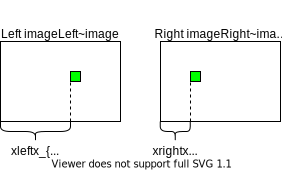

In [8]:
from IPython.core.display import SVG
SVG(filename='two_camera_images.svg')

Having two images with known landmark positions in image coordinates (pixels), it turns out that we can calculate the depth between camera and the landmark.

To do so, let's draw a simple scheme of two pinholes cameras' setup and derive the equation for depth, or forward distance, between the camera and the landmark.

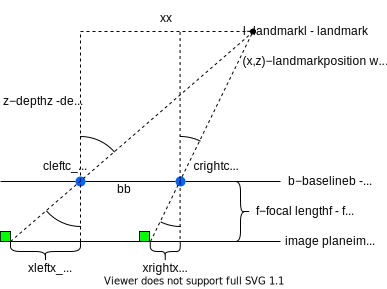

In [9]:
from IPython.core.display import SVG
SVG(filename='camera_model_only.svg')

On the preceding image $l$ is the landmark, $(x, z)$ is the landmark position w.r.t. the left camera $c_{left}$ (meters). We want to find $z$, depth of the landmark. By design, the focal length $f$ (in pixels) and baseline $b$, which is the horizontal distance between left and right cameras (in meters) are known.

From the  similar triangles (marked with arcs) and under assumption that the optical axes of the cameras are parallel we have (for simplicty $x_{left} = x_{l}, x_{right} = x_r$):
$$\frac{z}{f} = \frac{x}{x_{l}} = \frac{x-b}{x_{r}}.$$
Now, expressing $x$ in terms of $x_{l}$ and $x_{r}$ gives:
$$x x_{r} = (x - b) x_{l}$$
$$x (x_{r} - x_{l}) = -b x_{l}$$
$$x = \frac{b x_{l}}{x_{l} - x_{r}}$$

Substituting it into previous equation:
$$\frac{z}{f} = \frac{b}{x_r - x_l}$$
we can derive the equation for depth, or $z$ as:
$$z = \frac{f b}{x_l - x_r}.$$

## Bayesian model

From the depth equation the measurement model for disparity $disparity = x_l - x_r$ can be written as:
$$disparity = x_l - x_r = y = \frac{f b}{z} + n,$$
where the state $z$ is the depth of the landmark (meters) and $n$ is the measurement noise (in pixels), all other terms were defined earlier. Despite of being simple it is a nonlinear model: $f(x_1 + x_2) \neq f(x_1) + f(x_2)$. 

This fact can be visualized by passing the state through our measurement function. After applying this transform evenly spaced samples from our state space become unevenly spaced:

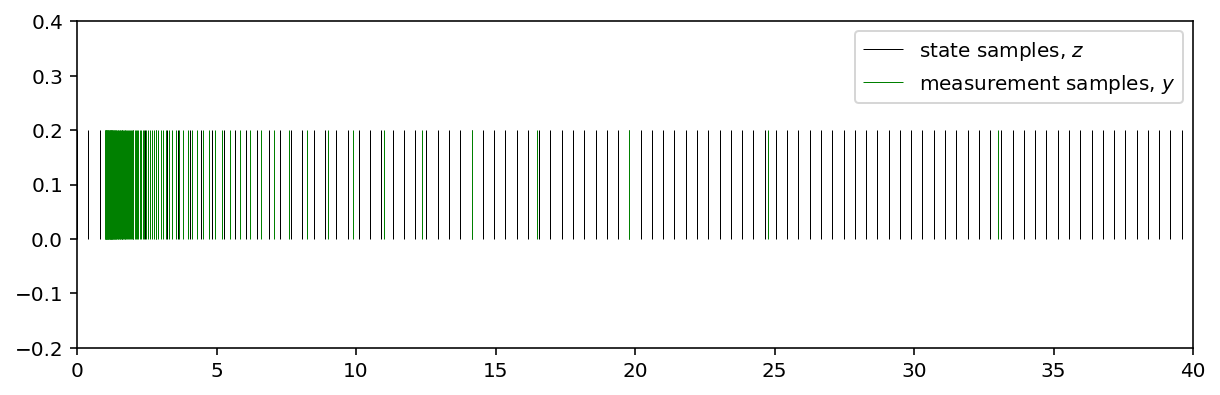

In [7]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import IPython

%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(1, 1, figsize = (10, 3))

# depth
z_space = np.linspace(1e-8, 40, 100)
# corresponding disparity measurements

measurement_space = 400 * 0.1 / z_space
ax.vlines(z_space, 0, 0.2, colors='k', label = "state samples, $z$", lw = 0.5)
ax.vlines(measurement_space, 0, 0.2, colors='green', label = "measurement samples, $y$", lw = 0.5)
ax.set_xlim(0, 40)
ax.set_ylim(-0.2, 0.4)
ax.legend()
plt.show()

The Bayesian update is defined as:
$$p(z|y) = \eta~p(y|z)~p(z),$$
where $\eta =  \frac{1}{p(y)} = \frac{1}{\int p(y|z)~p(z)~dz}$ is the normalizer.

To perform such update, the probabilities of $p(y|z)$ and $p(z)$ must be known. Our choice is to define the measurement noise as zero-mean Gaussian $n \sim N(0, R)$. Thus:
$$p(y|z) = N\left(\frac{f b}{z}, R\right) = \frac{1}{\sqrt{2 \pi R}} exp\left(-\frac{1}{2 R} \left(y - \frac{f b}{z}\right)^2\right).$$
We also asssume that the prior is Gaussian:
$$p(z) = N(z^{-}, P^{-}) = \frac{1}{\sqrt{2 \pi P^{-}}} exp\left(-\frac{1}{2 P^{-}} (z - z^{-})^2\right).$$

The Bayesian framework consists of the following operations:
1. Get the prior $p(z)$ over the state space $z$, given the current estimate $z^{-}$.
2. Obtain the measurement $y$.
3. Calculate the measurement likelihood using $p(y|z)$.
4. Calculate the posterior $p(z|y)$ using Bayes rule.

## Visualization

To illustrate how this nonlinearity affects the pdf of the posterior it is possible to perform numerical experiments. For such an experiment, the selected parameters are the following:
$$z^{-} = 20~[m],~P^{-} = 9~[m^2],~f = 400~[pixel],~b = 0.1~[m],~R = 0.09~[pixel^2].$$

The parameters for posterior calculation:
$$z_{true} = 22~[m],~y_{meas} = \frac{f b}{z_{true}} + 1~[pixel].$$

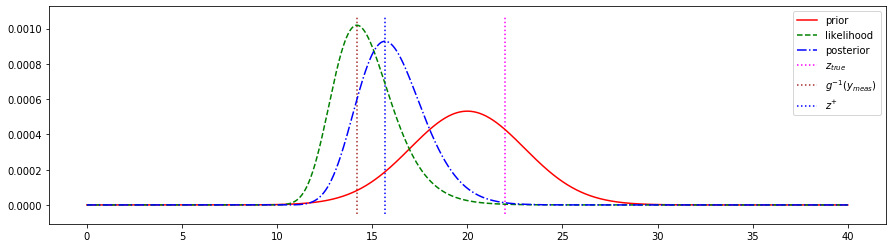

In [4]:
# prior parameters
z_prior = 20
P_prior = 9
f = 400
b = 0.1
R = 0.09

# measurement parameters
z_true = 22
noise = 1.0
y_meas = f * b / z_true + noise

fig, ax = plt.subplots(1, 1, figsize = (15, 4))

# prior
z_space = np.linspace(1e-8, 40, 10000)
priors = stats.norm.pdf(z_space, loc = z_prior, scale = np.sqrt(P_prior))
priors = priors / priors.sum()
ax.plot(z_space, priors, 'r-', label = "prior")

# likelihood
measurement_space = 400 * 0.1 / z_space
likelihoods = stats.norm.pdf(measurement_space, loc = y_meas, scale = np.sqrt(R))
likelihoods = likelihoods / likelihoods.sum()
ax.plot(z_space, likelihoods, 'g--', label = "likelihood")

# posterior
posteriors = priors * likelihoods
posteriors = posteriors / np.sum(posteriors)
ax.plot(z_space, posteriors, 'b-.', label = "posterior")

ymin, ymax = ax.get_ylim()
ax.vlines([z_true], ymin, ymax, colors = 'magenta', linestyles = 'dotted', label = '$z_{true}$')

zFromMeas = f * b / y_meas
ax.vlines([zFromMeas], ymin, ymax, colors = 'brown', linestyles = 'dotted', label = '$g^{-1}(y_{meas})$')

maxPosterior = np.argmax(posteriors)
ax.vlines([z_space[maxPosterior]], ymin, ymax, colors = 'blue', linestyles = 'dotted', label = '$z^{+}$')

ax.legend()

The maximum likelihood estimation (MLE) can be utilized when we want to use only the measurements and have no prior information about possible system state. It helps to find the answer to the following question: which value of $z$ is most probable given the measurement $y$?

However, if we know the prior distribution of our parameter of interest, it is generally a good idea to take it into account. The incorporation of the measurement results in more concentrated (less uncertainty) posterior about the state than the prior.

We can find the most probable posterior value for this concrete example by visual inspection of the posterior PDF. However, it is not the case for most real-life problems. To overcome this problem the maximum a posteriori (MAP) approach can be utilized. It is used to find the *peak* of the posterior.

## Maximum Likelihood estimation

Talking about the maximum likelihood estimation we seek for a value that maximizes the likelihood of our measurement, or data, given the state $z$:
$$\hat{x}_{mle} = \underset{x}{arg~max}~p(y|x),$$
going to the $log$ space:
$$\hat{x}_{mle} = \underset{x}{arg~min}~(-ln(p(y|x))).$$
*Note*: if we want to find MLE for a number of measurements, or samples under assumption that they are undepended, we replace $p(y|x)$ by the product of individual samples probabilities: $\underset{i}{\prod} p(y_i|x)$. This leads to the following $\hat{x}_{mle}$:
$$\hat{x}_{mle} = \underset{x}{arg~min}~(-\underset{i}{\sum}ln(p(y_i|x))).$$

For stereo-camera depth estimate:
$$\hat{z}_{mle} = \underset{z}{arg~min}~J_{mle}(z),$$
where $J_{mle}(z)$ can be found as:
$$J_{mle}(z) = \frac{1}{2 R} \left(y - \frac{f b}{z}\right)^2,$$
after dropping the constants that do not depend on $x$.

## Maximum a Posteriori estimation
When we are talking about maximum a posteriori estimation we assume that we want to find the single state value $x$ that maximizes the true posterior:
$$\hat{x}_{map} = \underset{x}{arg~max}~p(x|y),$$
or, alternatively, because $log$ is the monotolically increasing function:
$$\hat{x}_{map} = \underset{x}{arg~min}~(-ln(p(x|y))).$$
Applying the Bayes rule we have:
$$\hat{x}_{map} = \underset{x}{arg~min}~(-ln(p(y|x)) - ln(p(x))),$$
where $p(y)$ is being dropped because it does not depend on $x$. Again, if we have a number of measurements $y_i$, we have to add their product that leads to the sum after switching to the $log$ space.

In the stereo-camera depth estimate we can write:
$$\hat{z}_{map} = \underset{z}{arg~min}~J_{map}(z),$$
where $J(z)$ is obtained by dropping the constants that do not depend on $x$:
$$J_{map}(z) = \frac{1}{2 R} \left(y - \frac{f b}{z}\right)^2 + \frac{1}{2 P^{-}} \left(z^{-} - z\right)^2$$

Both MLE and MAP estimates can be found using a number of numerical optimization techniques by minimizing our target cost functions $J_{mle}$ or $J_{map}$.

Let's go back and find the MLE and MAP estimates of $z$:

ML estimate: 14.19354712952584
MAP estimate:  15.671431302257346


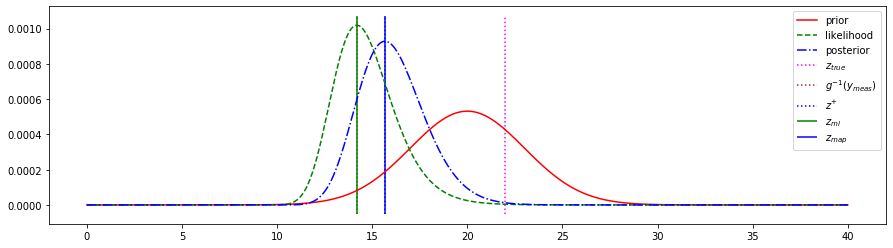

In [5]:
from scipy.optimize import minimize

Jz_mle = lambda z: 1.0 / (2.0 * R) * (y_meas - f * b / z) ** 2

ml_estimate = minimize(Jz_mle, 1e-8).x[0]

print("ML estimate:", ml_estimate)

Jz_map = lambda z: 1.0 / (2.0 * R) * (y_meas - f * b / z) ** 2 + \
        1.0 / (2.0 * P_prior) * (z_prior - z) ** 2

map_estimate = minimize(Jz_map, 1e-8).x[0]
print("MAP estimate: ", map_estimate)

ax.vlines([ml_estimate], ymin, ymax, colors = 'green', linestyles = '-', label = '$z_{ml}$')
ax.legend()

ax.vlines([map_estimate], ymin, ymax, colors = 'blue', linestyles = '-', label = '$z_{map}$')
ax.legend()

IPython.display.display(fig)

To test whether or not the estimators find the true value of $z$ the simulations can be performed, estimating the residual between true and estimated states.

Mean error MLE and true state: 0.5604994621492437
Variance of the error:  14.222683024537512
Mean error MAP and true state: -0.289582509033731
Variance of the error:  4.459397934201687


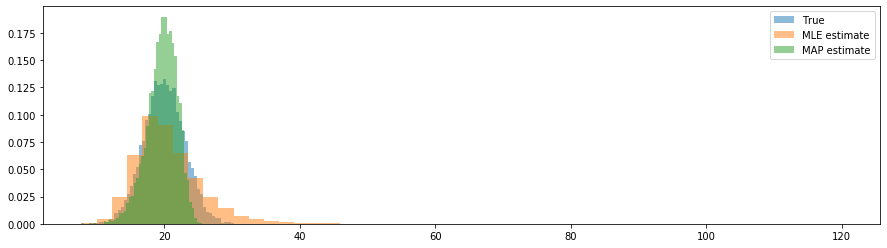

In [6]:
results = {'true_state' : [], 'measurement' : [], "map_estimate" : [], "mle_estimate" : []}

for i in range(0, 10000):
    z_true = np.random.normal(z_prior, np.sqrt(P_prior))
    y_meas = np.random.normal(f * b / z_true, np.sqrt(R))
    
    Jz_mle = lambda z: 1.0 / (2.0 * R) * (y_meas - f * b / z) ** 2
    mle_estimate = minimize(Jz_mle, 1e-8).x[0]
    
    Jz_map = lambda z: 1.0 / (2.0 * R) * (y_meas - f * b / z) ** 2 + \
        1.0 / (2.0 * P_prior) * (z_prior - z) ** 2
    map_estimate = minimize(Jz_map, 1e-8).x[0]

    results['true_state'].append(z_true)
    results['mle_estimate'].append(mle_estimate)
    results['map_estimate'].append(map_estimate)
    
true_results = np.array(results['true_state'])
mle_results = np.array(results['mle_estimate'])
map_results = np.array(results['map_estimate'])

fig, ax = plt.subplots(1, 1, figsize = (15, 4))
ax.hist(true_results, bins=50, alpha = 0.5, density = True, label = "True");
ax.hist(mle_results, bins=50, alpha = 0.5, density = True, label = "MLE estimate");
ax.hist(map_results, bins=50, alpha = 0.5, density = True, label = "MAP estimate");
ax.legend()

print("Mean error MLE and true state:", np.mean(mle_results - true_results))
print("Variance of the error: ", np.mean((mle_results  - true_results) ** 2))

print("Mean error MAP and true state:", np.mean(map_results - true_results))
print("Variance of the error: ", np.mean((map_results  - true_results) ** 2))

When selecting between MLE and MAP estimators it is a good practice to use MAP when the prior is given or can be inferred from experiments or researcher's intuition. Also, it is important to note that if the prior is a uniform distribution, MAP becomes an equivalent to MLE.

Both MLE and MAP estimators are biased even for such vanilla example. Why it happens and what to do with that? 
There is no straightforward answer: it depends on the problem. One of approaches that tackle this problem is the Bias-Variance decomposition.